In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from main.utils import data_manage_utils, train_utils

importlib.reload(train_utils)
importlib.reload(data_manage_utils)

loading_folder = "2024_06_17-0642"
loading_spec = "RF"

ROOT_PATH = os.path.abspath("../../")
TRAIN_DATA_FOLDER = os.path.join(ROOT_PATH, "data/training/training_results/", loading_spec, loading_folder)

# Finding corresponding prep data folder
settings_path = os.path.join(TRAIN_DATA_FOLDER, "estimation_settings.json")
PREP_DATA_FOLDER = data_manage_utils.find_data_path_by_settings_file(settings_path,ROOT_PATH)

In [2]:
pert_result_df_path = os.path.join(TRAIN_DATA_FOLDER,"pert_out_df.pkl.gz")

pert_df = pd.read_pickle(pert_result_df_path, compression="gzip")

pert_cols = list(set(pert_df.columns) - {"ARR_MIN_OF_DAY_COS", "ARR_MIN_OF_DAY_SIN", "ARR_DAY_SIN", "ARR_DAY_COS"})
USE_TH = False
if USE_TH:
    pert_cols = ["TEMP(C)","WIND_SPEED(KMH)","REL_HUMIDITY(PERCENT)","WIND_DRCT(DEG)", "SEA_LEVEL_PRESSURE(MILLIBAR)"]

pert_df

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
0,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280000,6.324600,560.293571,...,0,0,0,0,0,1.00,2,APPROACH_SPEED(KMH)<6386798>,2,2
1,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,258.917008,6.324600,560.293571,...,0,0,0,0,0,1.00,2,APPROACH_SPEED(KMH)<6386798>,2,2
2,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.642992,6.324600,560.293571,...,0,0,0,0,0,1.00,2,APPROACH_SPEED(KMH)<6386798>,2,2
3,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,258.554016,6.324600,560.293571,...,0,0,0,0,0,1.00,2,APPROACH_SPEED(KMH)<6386798>,2,2
4,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,260.005984,6.324600,560.293571,...,0,0,0,0,0,1.00,2,APPROACH_SPEED(KMH)<6386798>,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081409,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.94,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081410,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.64,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081411,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.96,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081412,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.62,0,RUNWAY_ERROR(PERC)<6600848>,3,1


In [3]:
pert_df[pert_df["pert_id"].isin(["TEMP(C)"])]

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y


In [4]:
y_test_pred = pd.DataFrame(data_manage_utils.load_numpy_from_pickle(os.path.join(TRAIN_DATA_FOLDER, "y_test_pred.pkl")))
y_test_pred

,0
0,2
1,0
2,1
3,2
4,0
...,...
65796,1
65797,1
65798,2
65799,0


In [5]:
X_test = pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "X_test_df.pkl"))
y_test = pd.DataFrame(pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "y_test_df.pkl")))
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [6]:
y_test

,ARR_DELAY_MINS
6386798,2
6824913,0
7556876,1
10772416,2
7282245,0
...,...
9980295,1
9983451,1
7026317,2
10352441,1


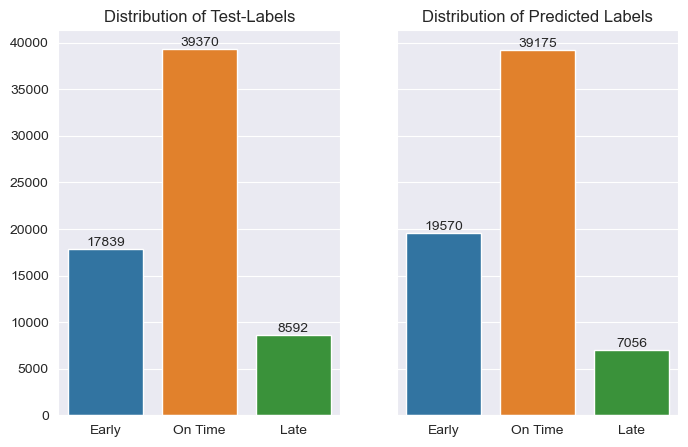

In [7]:
fig, axes = plt.subplots(1,2,figsize=(8,5), sharey=True)
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test.value_counts().sort_index()), ax=axes[0])
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test_pred.value_counts().sort_index()), ax=axes[1])
axes[0].set_title("Distribution of Test-Labels")
axes[1].set_title("Distribution of Predicted Labels")
axes[0].bar_label(axes[0].containers[0])
axes[1].bar_label(axes[1].containers[0])
plt.show()

In [8]:
def print_measures(y_pred, y_true, true_labels):
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred[y_pred.columns[0]]
    if type(y_true) == pd.DataFrame:
        y_true = y_true[y_true.columns[0]]
    ret_dict = {}
    print(20*"-")
    print(f"Global measures")
    print(f"Number of entries: {len(y_pred)}")
    acc = accuracy_score(y_true=y_true, y_pred=y_pred, normalize=True)
    ret_dict.update({"acc" : acc})
    print(f"Accuracy: {acc:.5f}")
    print(f"Precision-µ: {precision_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"Recall-µ: {recall_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"F1-Score-µ: {f1_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print("=")
    print(f"Precision-M: {precision_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"Recall-M: {recall_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"F1-Score-M: {f1_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    for label in true_labels:
        if (label in y_pred) or (label in y_true):
            y_pred_filtered = [1 if val == label else 0 for val in y_pred]
            y_true_filtered = [1 if val == label else 0 for val in y_true]
            print(20*"-")
            print(f"Measures for label '{label}'")
            print(f"Number of entries: {sum(y_true_filtered)}")
            prec = precision_score(y_true=y_true_filtered, y_pred=y_pred_filtered)
            print(f"Precision score: {prec:.5f}")
            print(f"Recall score: {recall_score(y_true=y_true_filtered, y_pred=y_pred_filtered):.5f}")
            ret_dict.update({"prec"+str(label) : prec})
    return ret_dict
real = print_measures(y_test_pred, y_test, [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73429
Precision-µ: 0.73429
Recall-µ: 0.73429
F1-Score-µ: 0.73429
=
Precision-M: 0.75099
Recall-M: 0.71565
F1-Score-M: 0.73029
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58298
Recall score: 0.63955
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78223
Recall score: 0.77836
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88776
Recall score: 0.72905


## Finding amount of alerts in the data.
The 2 tables below depict the amount of alarmed perturbation cases within the result data.
The first table groups the data, such that only the predicted target with its min and max value within a given perturbation scenario is printed. 
This is used to find scenarios, where the min and max values deviate which means that the perturbation lead to varying results

In [9]:
X_pert_res = pert_df.groupby("pert_id").agg({'y':['min','max']})["y"]
X_pert_res

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,1
1HOUR_PRECIPITATION(INCH)<10003947>,1,1
1HOUR_PRECIPITATION(INCH)<10004727>,1,1
1HOUR_PRECIPITATION(INCH)<10006126>,1,1
1HOUR_PRECIPITATION(INCH)<10006791>,1,1
...,...,...
WIND_SPEED(KMH)<9998396>,0,0
WIND_SPEED(KMH)<9998430>,2,2
WIND_SPEED(KMH)<9998460>,1,1


In [10]:
pert_alerts = X_pert_res[~(X_pert_res["min"] == X_pert_res["max"])]
pert_alerts

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10026093>,0,1
1HOUR_PRECIPITATION(INCH)<10042426>,0,1
1HOUR_PRECIPITATION(INCH)<10042665>,0,1
1HOUR_PRECIPITATION(INCH)<10055239>,0,1
1HOUR_PRECIPITATION(INCH)<10055441>,0,1
...,...,...
WIND_SPEED(KMH)<9953591>,0,1
WIND_SPEED(KMH)<9967800>,1,2
WIND_SPEED(KMH)<9979208>,0,1


Now we want to find all single perturbation rows within the result and find all that are related to the alarmed scenarios.

In [11]:
list(pert_alerts.index)
pert_df[pert_df["pert_id"].isin(list(pert_alerts.index))]

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
1634,-1,95,55,-0.974928,-0.222521,-0.562805,-0.82659,257.428000,9.043416,1075.157934,...,0,0,0,0,0,1.00,0,APPROACH_SPEED(KMH)<6633734>,2,0
1635,-1,95,55,-0.974928,-0.222521,-0.562805,-0.82659,257.067601,9.043416,1075.157934,...,0,0,0,0,0,1.00,0,APPROACH_SPEED(KMH)<6633734>,2,0
1636,-1,95,55,-0.974928,-0.222521,-0.562805,-0.82659,257.788399,9.043416,1075.157934,...,0,0,0,0,0,1.00,0,APPROACH_SPEED(KMH)<6633734>,2,0
1637,-1,95,55,-0.974928,-0.222521,-0.562805,-0.82659,256.707202,9.043416,1075.157934,...,0,0,0,0,0,1.00,0,APPROACH_SPEED(KMH)<6633734>,2,0
1638,-1,95,55,-0.974928,-0.222521,-0.562805,-0.82659,258.148798,9.043416,1075.157934,...,0,0,0,0,0,1.00,0,APPROACH_SPEED(KMH)<6633734>,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14081143,-5,171,65,0.433884,-0.900969,-0.555570,0.83147,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.94,0,RUNWAY_ERROR(PERC)<6949065>,3,0
14081144,-5,171,65,0.433884,-0.900969,-0.555570,0.83147,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.64,0,RUNWAY_ERROR(PERC)<6949065>,3,1
14081145,-5,171,65,0.433884,-0.900969,-0.555570,0.83147,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.96,0,RUNWAY_ERROR(PERC)<6949065>,3,0
14081146,-5,171,65,0.433884,-0.900969,-0.555570,0.83147,255.576000,9.000744,1525.176514,...,0,0,0,0,0,0.62,0,RUNWAY_ERROR(PERC)<6949065>,3,1


## Creating the Ourcome DF
Usign the last four columns in the above df, we see the mode, index and results of ALL perturbation scenarios. Not only the alarmed values. 

In [12]:
pert_outcomes = pert_df[pert_df.columns[-4:]]
pert_outcomes

,y_true,pert_id,level,y
0,2,APPROACH_SPEED(KMH)<6386798>,2,2
1,2,APPROACH_SPEED(KMH)<6386798>,2,2
2,2,APPROACH_SPEED(KMH)<6386798>,2,2
3,2,APPROACH_SPEED(KMH)<6386798>,2,2
4,2,APPROACH_SPEED(KMH)<6386798>,2,2
...,...,...,...,...
14081409,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081410,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081411,0,RUNWAY_ERROR(PERC)<6600848>,3,1
14081412,0,RUNWAY_ERROR(PERC)<6600848>,3,1


## Disassembling the perturbation ID colun to make it more readable and get index and column label information

In [13]:
def disassemble_pert_id(row):
    s = row["pert_id"].split("<")
    col = s[0]
    idx = s[1][:-1]
    val = row[col]
    return [col,val,idx]

col_values = pert_df.apply(lambda row: disassemble_pert_id(row), axis=1)

In [14]:
col_values = pd.DataFrame(list(col_values.to_numpy()), columns=["column","val","idx"])
col_values

,column,val,idx
0,APPROACH_SPEED(KMH),259.280000,6386798
1,APPROACH_SPEED(KMH),258.917008,6386798
2,APPROACH_SPEED(KMH),259.642992,6386798
3,APPROACH_SPEED(KMH),258.554016,6386798
4,APPROACH_SPEED(KMH),260.005984,6386798
...,...,...,...
14081409,RUNWAY_ERROR(PERC),0.940000,6600848
14081410,RUNWAY_ERROR(PERC),0.640000,6600848
14081411,RUNWAY_ERROR(PERC),0.960000,6600848
14081412,RUNWAY_ERROR(PERC),0.620000,6600848


In [15]:
col_values[col_values["column"] == "REL_HUMIDITY(PERCENT)"]

,column,val,idx
6251095,REL_HUMIDITY(PERCENT),93.18000,6386798
6251096,REL_HUMIDITY(PERCENT),92.99364,6386798
6251097,REL_HUMIDITY(PERCENT),93.36636,6386798
6251098,REL_HUMIDITY(PERCENT),92.80728,6386798
6251099,REL_HUMIDITY(PERCENT),93.55272,6386798
...,...,...,...
7501309,REL_HUMIDITY(PERCENT),58.68018,6600848
7501310,REL_HUMIDITY(PERCENT),56.94408,6600848
7501311,REL_HUMIDITY(PERCENT),58.79592,6600848
7501312,REL_HUMIDITY(PERCENT),56.82834,6600848


In [16]:
pert_outcomes["column"] = list(col_values["column"])
pert_outcomes["val"] = list(col_values["val"])
pert_outcomes["idx"] = list(col_values["idx"])
pert_outcomes

C:\Users\chrig\AppData\Local\Temp\ipykernel_3528\1567013798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_outcomes["column"] = list(col_values["column"])
C:\Users\chrig\AppData\Local\Temp\ipykernel_3528\1567013798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_outcomes["val"] = list(col_values["val"])
C:\Users\chrig\AppData\Local\Temp\ipykernel_3528\1567013798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,y_true,pert_id,level,y,column,val,idx
0,2,APPROACH_SPEED(KMH)<6386798>,2,2,APPROACH_SPEED(KMH),259.280000,6386798
1,2,APPROACH_SPEED(KMH)<6386798>,2,2,APPROACH_SPEED(KMH),258.917008,6386798
2,2,APPROACH_SPEED(KMH)<6386798>,2,2,APPROACH_SPEED(KMH),259.642992,6386798
3,2,APPROACH_SPEED(KMH)<6386798>,2,2,APPROACH_SPEED(KMH),258.554016,6386798
4,2,APPROACH_SPEED(KMH)<6386798>,2,2,APPROACH_SPEED(KMH),260.005984,6386798
...,...,...,...,...,...,...,...
14081409,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.940000,6600848
14081410,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.640000,6600848
14081411,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.960000,6600848
14081412,0,RUNWAY_ERROR(PERC)<6600848>,3,1,RUNWAY_ERROR(PERC),0.620000,6600848


In [17]:
pert_view = pert_outcomes.groupby(["pert_id","y_true"]).first().reset_index().set_index('pert_id')
pert_view

,y_true,level,y,column,val,idx
pert_id,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791
...,...,...,...,...,...,...
WIND_SPEED(KMH)<9998396>,0,3,0,WIND_SPEED(KMH),12.964,9998396
WIND_SPEED(KMH)<9998430>,2,3,2,WIND_SPEED(KMH),16.668,9998430
WIND_SPEED(KMH)<9998460>,1,3,1,WIND_SPEED(KMH),14.816,9998460


## Create pert_alarm column
The pert_view DataFrame has been established. Now we add some flags to easily find whether or not a given entry is part of a "alarmed" entry or not.   

In [18]:
pert_view["pert_alarm"] = [idx in pert_alerts.index for idx in pert_view.index]
faulty = pert_view[pert_view["y_true"] != pert_view["y"]]
faulty_and_changed = faulty[faulty["pert_alarm"]]
pert_view["class_error"] = [idx in faulty.index for idx in pert_view.index]
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9998396>,0,3,0,WIND_SPEED(KMH),12.964,9998396,False,False
WIND_SPEED(KMH)<9998430>,2,3,2,WIND_SPEED(KMH),16.668,9998430,False,False
WIND_SPEED(KMH)<9998460>,1,3,1,WIND_SPEED(KMH),14.816,9998460,False,False


In [19]:
pert_view[pert_view["pert_alarm"]]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055441,True,False
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9953591>,0,3,0,WIND_SPEED(KMH),25.928,9953591,True,False
WIND_SPEED(KMH)<9967800>,1,3,1,WIND_SPEED(KMH),16.668,9967800,True,False
WIND_SPEED(KMH)<9979208>,0,3,1,WIND_SPEED(KMH),13.890,9979208,True,True


In [20]:
_t = pert_view[(pert_view["y"] == 0) | (pert_view["y"] == 2)]
_t 

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10007195>,2,3,2,1HOUR_PRECIPITATION(INCH),0.475,10007195,False,False
1HOUR_PRECIPITATION(INCH)<10007286>,2,3,2,1HOUR_PRECIPITATION(INCH),0.035,10007286,False,False
1HOUR_PRECIPITATION(INCH)<10007352>,2,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007352,False,False
1HOUR_PRECIPITATION(INCH)<10007615>,1,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007615,False,True
1HOUR_PRECIPITATION(INCH)<10007880>,2,3,2,1HOUR_PRECIPITATION(INCH),0.010,10007880,False,False
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9998109>,2,3,2,WIND_SPEED(KMH),12.964,9998109,False,False
WIND_SPEED(KMH)<9998159>,1,3,0,WIND_SPEED(KMH),12.964,9998159,False,True
WIND_SPEED(KMH)<9998396>,0,3,0,WIND_SPEED(KMH),12.964,9998396,False,False


In [21]:
#X_test.loc[[10026093, 10022088]].to_csv("result.csv", sep=",")

# MARKER FOR CSV PRINT

In [22]:
#y_test_pred.iloc[X_test.index.get_loc(10026093)]

## First measures for subsets on perturbation data. Option per option view

In [23]:
counts = pert_view[pert_view["pert_alarm"]]["column"].value_counts()
percs = pert_view[pert_view["pert_alarm"]]["column"].value_counts(normalize=True)*100
pd.concat([counts, percs], axis=1, keys=['count', 'percenage'])

,count,percenage
1HOUR_PRECIPITATION(INCH),4777,33.752561
APPROACH_SPEED(KMH),2658,18.780471
SEA_LEVEL_PRESSURE(MILLIBAR),1727,12.202360
RUNWAY_ERROR(PERC),1510,10.669116
REL_HUMIDITY(PERCENT),1180,8.337455
PARKING_AREA(SQM),604,4.267646
WIND_DRCT(DEG),373,2.635484
TAIL_HEIGHT(M),361,2.550696
DEWPOINT_TEMP(C),310,2.190348
WIND_SPEED(KMH),292,2.063167


Find number of alarms by level

In [24]:
counts_total = pert_view["level"].value_counts()
counts = pert_view[pert_view["pert_alarm"]]["level"].value_counts()
percs = (counts / counts_total) *100
#perc_of_all = pd.DataFrame([x/len(pert_view)*100 for x in counts])
pd.concat([counts_total,counts, percs], axis=1, keys=['total # of options', '# of alarming options', 'alarm percentages'])

,total # of options,# of alarming options,alarm percentages
3,592209,10530,1.778088
2,197403,3623,1.835332


In [25]:
print(f"All lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1)]["column"].unique()))
print(f"Alarmed lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 1 pert columns: 
[]
Alarmed lvl 1 pert columns: 
[]


In [26]:
print(f"All lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3)]["column"].unique()))
print(f"Alarmed lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'RUNWAY_ERROR(PERC)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'VISIBILITY(MILES)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']
Alarmed lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'RUNWAY_ERROR(PERC)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'VISIBILITY(MILES)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']


In [27]:
pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055441,True,False
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9953591>,0,3,0,WIND_SPEED(KMH),25.928,9953591,True,False
WIND_SPEED(KMH)<9967800>,1,3,1,WIND_SPEED(KMH),16.668,9967800,True,False
WIND_SPEED(KMH)<9979208>,0,3,1,WIND_SPEED(KMH),13.890,9979208,True,True


All columns are present when looking into the perturbation levels

In [30]:
lvl3_and_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == True]
lvl3_and_not_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == False]

if 1 in pert_view["level"].values:
    lvl1_and_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == True]
    lvl1_and_not_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == False]

    print(f"Pert lvl 1 accuracy within alarmed values:\n\t{(len(lvl1_and_alarmed[lvl1_and_alarmed['class_error'] == False]) / len(lvl1_and_alarmed)) * 100:.2f}%")
    print(f"Pert lvl 1 accuracy within non-alarmed values:\n\t{(len(lvl1_and_not_alarmed[lvl1_and_not_alarmed['class_error'] == False]) / len(lvl1_and_not_alarmed)) * 100:.2f}%")
    print(40*"=")
print(f"Pert lvl 3 accuracy within alarmed values:\n\t{(len(lvl3_and_alarmed[lvl3_and_alarmed['class_error'] == False]) / len(lvl3_and_alarmed)) * 100:.2f}%")
print(f"Pert lvl 3 accuracy within non-alarmed values:\n\t{(len(lvl3_and_not_alarmed[lvl3_and_not_alarmed['class_error'] == False]) / len(lvl3_and_not_alarmed)) * 100:.2f}%")

Pert lvl 3 accuracy within alarmed values:
	49.71%
Pert lvl 3 accuracy within non-alarmed values:
	73.75%


In [31]:
pert_view[pert_view['pert_alarm'] & pert_view['class_error']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055554>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055554,True,True
1HOUR_PRECIPITATION(INCH)<10055618>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055618,True,True
...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9927066>,0,3,1,WIND_SPEED(KMH),14.816,9927066,True,True
WIND_SPEED(KMH)<9929965>,1,3,2,WIND_SPEED(KMH),20.372,9929965,True,True
WIND_SPEED(KMH)<9979208>,0,3,1,WIND_SPEED(KMH),13.890,9979208,True,True


In [32]:
# Prepare values.
total = len(pert_view)
error = len(pert_view[pert_view['class_error']])
no_error = len(pert_view[~pert_view['class_error']])
alarm = len(pert_view[pert_view['pert_alarm']])
no_alarm = len(pert_view[~pert_view['pert_alarm']])
# Combined
alarm_and_error = len(pert_view[pert_view['pert_alarm'] & pert_view['class_error']])
alarm_and_no_error = len(pert_view[pert_view['pert_alarm'] & ~pert_view['class_error']])
no_alarm_and_error = len(pert_view[~pert_view['pert_alarm'] & pert_view['class_error']])
no_alarm_and_no_error = len(pert_view[~pert_view['pert_alarm'] & ~pert_view['class_error']])

print(f"Basics:\n{40*'-'}")
print(f"Accuracy for all perturbation options: {(1 - error/total)*100:.3f}%")
print(f"Nr. of perturbation alarms for all perturbation options: {(alarm/total)*100:.3f}%")
print(40*"=")
print(f"Combined metrics:\n{40*'-'}")
print(f"Of all wrong classifications, % of alarmed cases: {(alarm_and_error/error)*100:.3f}%")
print(f"Of all true classifications, % of alarmed cases: {(alarm_and_no_error/no_error)*100:.3f}%")
print(40*'-')
print(f"Of all alarmed, % of true classifications: {(alarm_and_no_error/alarm)*100:.3f}%")
print(f"Of all alarmed, % of wrong classifications: {(alarm_and_error/alarm)*100:.3f}%")
print(40*'-')
print(f"Of all non-alarmed, % of true classifications: {(no_alarm_and_no_error/no_alarm)*100:.3f}%")
print(f"Of all non-alarmed, % of wrong classifications: {(no_alarm_and_error/no_alarm)*100:.3f}%")
print(40*'-')

Basics:
----------------------------------------
Accuracy for all perturbation options: 73.429%
Nr. of perturbation alarms for all perturbation options: 1.792%
Combined metrics:
----------------------------------------
Of all wrong classifications, % of alarmed cases: 3.401%
Of all true classifications, % of alarmed cases: 1.210%
----------------------------------------
Of all alarmed, % of true classifications: 49.580%
Of all alarmed, % of wrong classifications: 50.420%
----------------------------------------
Of all non-alarmed, % of true classifications: 73.864%
Of all non-alarmed, % of wrong classifications: 26.136%
----------------------------------------


In [33]:
cols = list(pert_view["column"].value_counts().index)
cols

['1HOUR_PRECIPITATION(INCH)',
 'APPROACH_SPEED(KMH)',
 'DEWPOINT_TEMP(C)',
 'PARKING_AREA(SQM)',
 'REL_HUMIDITY(PERCENT)',
 'RUNWAY_ERROR(PERC)',
 'SEA_LEVEL_PRESSURE(MILLIBAR)',
 'TAIL_HEIGHT(M)',
 'TEMP(C)',
 'VISIBILITY(MILES)',
 'WIND_DRCT(DEG)',
 'WIND_SPEED(KMH)']

C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves
C:\Users\chrig\anaconda3\envs\ma-env39\lib\site-packages\seaborn\distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

,y_true,level,y,column,val,pert_alarm,class_error
idx,,,,,,,
10001243,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False
10003947,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10004727,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
10006126,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10006791,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
...,...,...,...,...,...,...,...
9998396,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998430,2,3,2,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998460,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False


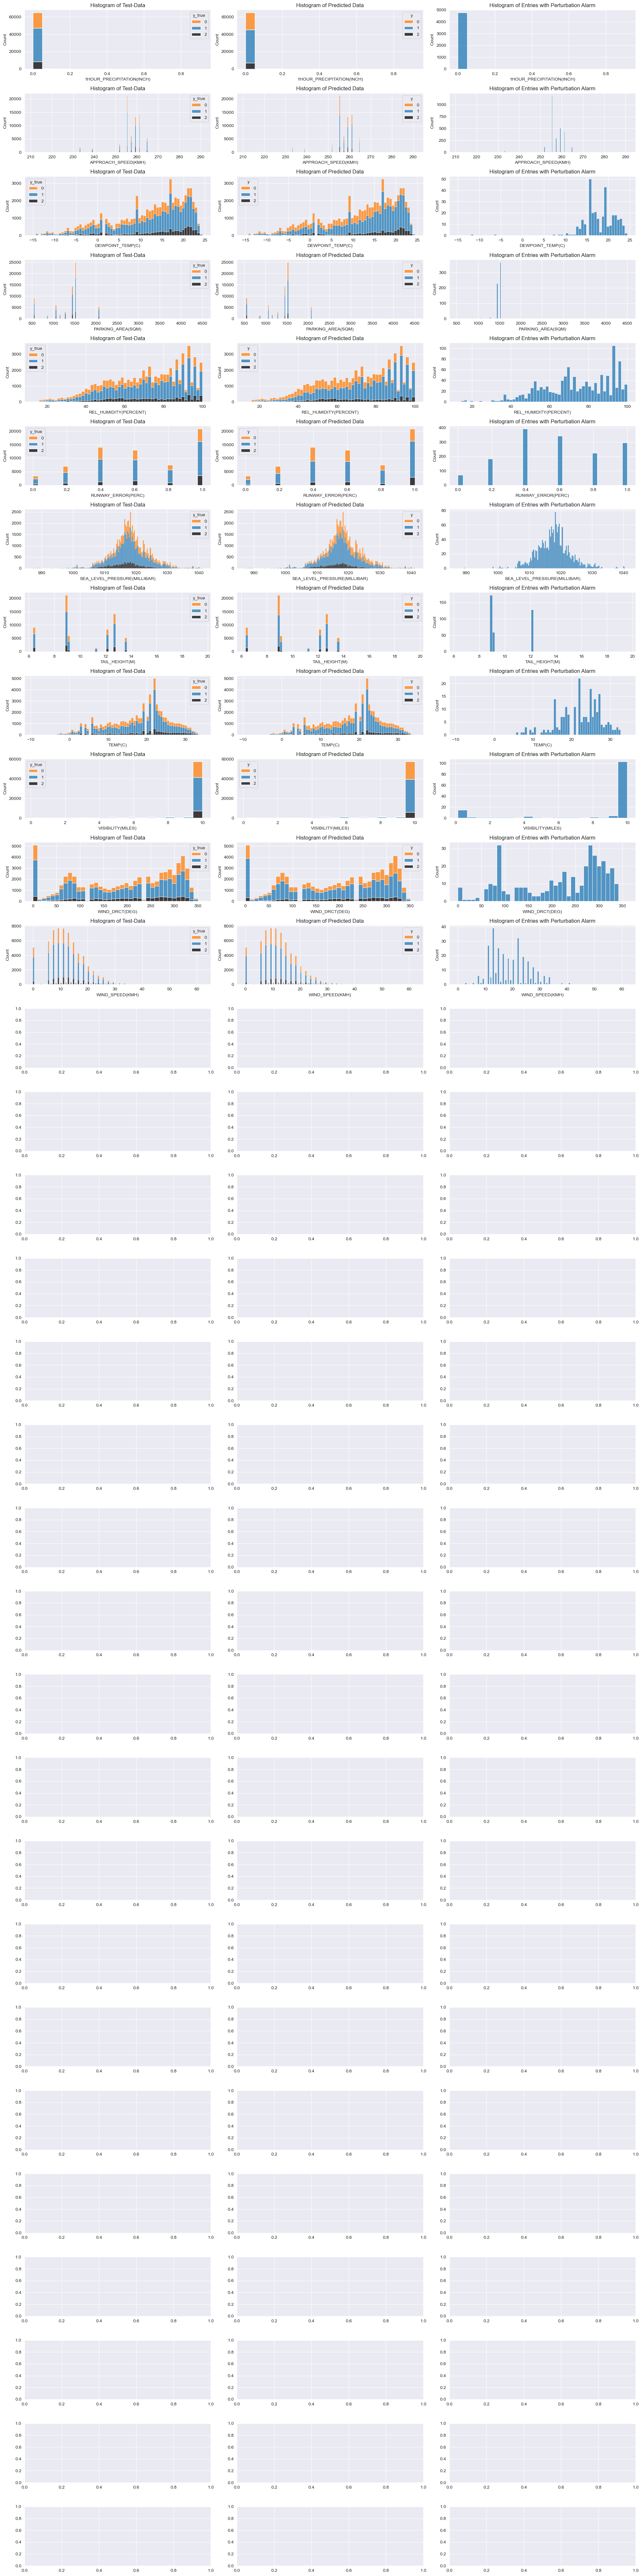

In [34]:
pert_view_alert = pert_view[pert_view["pert_alarm"] == True]

fig, axes = plt.subplots(len(pert_cols),3, figsize=(20,80))

count = 0
for col in cols:
    p_row = int(count / 3)
    bins = np.histogram_bin_edges(pert_view[pert_view["column"] == col]["val"], bins='auto')
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y_true", multiple="stack", ax=axes[p_row][0], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][0].set_title("Histogram of Test-Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y", multiple="stack", ax=axes[p_row][1], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][1].set_title("Histogram of Predicted Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view_alert[pert_view_alert["column"] == col], x = "val", multiple="stack", ax=axes[p_row][2], bins = bins)
    axes[p_row][2].set_title("Histogram of Entries with Perturbation Alarm")
    ax.set(xlabel=col)
    count += 3
fig.tight_layout()
pert_view.groupby("idx").first()

In [35]:
def to_set(x):

    return set(x)

pert_view["y_outcomes"] = list(pert_outcomes[["pert_id" , "y"]].groupby("pert_id")["y"].apply(set).reset_index()["y"].to_numpy())
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes
pert_id,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1}
...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9998396>,0,3,0,WIND_SPEED(KMH),12.964,9998396,False,False,{0}
WIND_SPEED(KMH)<9998430>,2,3,2,WIND_SPEED(KMH),16.668,9998430,False,False,{2}
WIND_SPEED(KMH)<9998460>,1,3,1,WIND_SPEED(KMH),14.816,9998460,False,False,{1}


In [36]:
def find_diff(x):
    return list(x.y_outcomes.difference({x.y}))

pert_view["changed_to"] = pert_view.apply( find_diff , axis = "columns")

In [37]:
def is_good_change(x):
    return x.y_true in x.changed_to

pert_view["corrected"] = list(pert_view[["y_true", "changed_to"]].apply(is_good_change, axis = "columns"))

In [38]:
def is_bad_change(x):
    if not x.class_error and x.changed_to:
        return True
    return False

pert_view["worsened"] = list(pert_view[["class_error", "changed_to"]].apply(is_bad_change, axis = "columns"))

In [39]:
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1},[],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9998396>,0,3,0,WIND_SPEED(KMH),12.964,9998396,False,False,{0},[],False,False
WIND_SPEED(KMH)<9998430>,2,3,2,WIND_SPEED(KMH),16.668,9998430,False,False,{2},[],False,False
WIND_SPEED(KMH)<9998460>,1,3,1,WIND_SPEED(KMH),14.816,9998460,False,False,{1},[],False,False


In [40]:
def get_first(x):
    return x[0]

def find_union(x):
    return set().union(*x)

def get_indicator(x):
    return sum(x) / len(pert_cols)

pert_test_results_th3 = pert_view[pert_view["level"] >= 3]
pert_test_results_th3 = pert_test_results_th3.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results_th2 = pert_view[pert_view["level"] >= 2]
pert_test_results_th2 = pert_test_results_th2.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results = pert_view.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0
10003947,1,1,False,{1},{},0.0,0.0
10004727,1,1,False,{1},{},0.0,0.0
10006126,1,1,False,{1},{},0.0,0.0
10006791,1,1,False,{1},{},0.0,0.0
...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0
9998430,2,2,False,{2},{},0.0,0.0
9998460,1,1,False,{1},{},0.0,0.0


# Working with pert_test_results

In [41]:
pert_test_results[pert_test_results["pert_alarm"]]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10026093,1,0,True,"{0, 1}",{1},0.193548,0.000000
10033431,2,2,True,"{1, 2}",{1},0.000000,0.064516
10042426,0,0,True,"{0, 1}",{1},0.000000,0.193548
10042665,1,0,True,"{0, 1}",{1},0.032258,0.000000
10042837,1,1,True,"{1, 2}",{2},0.000000,0.161290
...,...,...,...,...,...,...,...
9988578,1,0,True,"{0, 1}",{1},0.096774,0.000000
9995030,1,1,True,"{0, 1}",{0},0.000000,0.129032
9997432,1,0,True,"{0, 1}",{1},0.032258,0.000000


In [42]:
pert_test_results[pert_test_results["pert_alarm"] == False]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0
10003947,1,1,False,{1},{},0.0,0.0
10004727,1,1,False,{1},{},0.0,0.0
10006126,1,1,False,{1},{},0.0,0.0
10006791,1,1,False,{1},{},0.0,0.0
...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0
9998430,2,2,False,{2},{},0.0,0.0
9998460,1,1,False,{1},{},0.0,0.0


In [43]:
pert_test_results_th2[pert_test_results_th2["pert_alarm"]]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10026093,1,0,True,"{0, 1}",{1},0.193548,0.000000
10033431,2,2,True,"{1, 2}",{1},0.000000,0.064516
10042426,0,0,True,"{0, 1}",{1},0.000000,0.193548
10042665,1,0,True,"{0, 1}",{1},0.032258,0.000000
10042837,1,1,True,"{1, 2}",{2},0.000000,0.161290
...,...,...,...,...,...,...,...
9988578,1,0,True,"{0, 1}",{1},0.096774,0.000000
9995030,1,1,True,"{0, 1}",{0},0.000000,0.129032
9997432,1,0,True,"{0, 1}",{1},0.032258,0.000000


In [44]:
#TODO CREATE NEW FUNCTIONS FOR TH2
pert_test_results = pert_test_results_th2

In [45]:
alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == True]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == True]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 6741
Accuracy: 0.49770
Precision-µ: 0.49770
Recall-µ: 0.49770
F1-Score-µ: 0.49770
=
Precision-M: 0.52512
Recall-M: 0.51651
F1-Score-M: 0.48565
--------------------
Measures for label '0'
Number of entries: 2800
Precision score: 0.46242
Recall score: 0.79321
--------------------
Measures for label '1'
Number of entries: 3630
Precision score: 0.59757
Recall score: 0.27080
--------------------
Measures for label '2'
Number of entries: 311
Precision score: 0.51536
Recall score: 0.48553


In [46]:
no_alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 59060
Accuracy: 0.76129
Precision-µ: 0.76129
Recall-µ: 0.76129
F1-Score-µ: 0.76129
=
Precision-M: 0.77214
Recall-M: 0.72635
F1-Score-M: 0.74628
--------------------
Measures for label '0'
Number of entries: 15039
Precision score: 0.62220
Recall score: 0.61094
--------------------
Measures for label '1'
Number of entries: 35740
Precision score: 0.79033
Recall score: 0.82991
--------------------
Measures for label '2'
Number of entries: 8281
Precision score: 0.90389
Recall score: 0.73820


In [47]:
pert_test_results[pert_test_results["corrected"] > 0.25]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10088834,1,0,True,"{0, 1}",{1},0.322581,0.0
10460674,1,0,True,"{0, 1}",{1},0.354839,0.0
10477279,1,0,True,"{0, 1}",{1},0.258065,0.0
10693030,1,0,True,"{0, 1}",{1},0.258065,0.0
10965751,1,0,True,"{0, 1}",{1},0.258065,0.0
5801062,1,0,True,"{0, 1}",{1},0.290323,0.0
5925498,1,0,True,"{0, 1}",{1},0.258065,0.0
5957018,1,0,True,"{0, 1}",{1},0.290323,0.0
6077448,0,1,True,"{0, 1}",{0},0.290323,0.0


In [48]:
pert_test_results[pert_test_results["worsened"] > 0]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10033431,2,2,True,"{1, 2}",{1},0.0,0.064516
10042426,0,0,True,"{0, 1}",{1},0.0,0.193548
10042837,1,1,True,"{1, 2}",{2},0.0,0.161290
10044045,1,1,True,"{0, 1}",{0},0.0,0.096774
10044360,1,1,True,"{1, 2}",{2},0.0,0.064516
...,...,...,...,...,...,...,...
9980742,0,0,True,"{0, 1}",{1},0.0,0.064516
9981281,1,1,True,"{0, 1}",{0},0.0,0.064516
9983451,1,1,True,"{0, 1}",{0},0.0,0.032258


[(0.0, 0.25)]

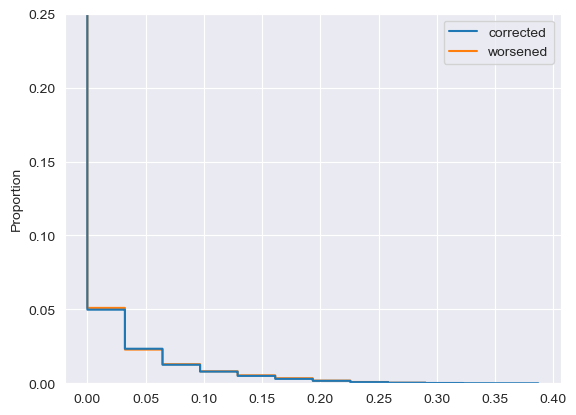

In [49]:
ax = sns.ecdfplot(data=pert_test_results[["corrected", "worsened"]], complementary=True)
ax.set(ylim=(0,0.25))

In [50]:
pert_test_results[pert_test_results["y_outcomes"].map(len) > 2]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
7028933,2,2,True,"{0, 1, 2}","{0, 1}",0.0,0.096774


In [51]:
pert_test_results["correct"] = pert_test_results["y_true"] == pert_test_results["y"]
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct
idx,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True
10003947,1,1,False,{1},{},0.0,0.0,True
10004727,1,1,False,{1},{},0.0,0.0,True
10006126,1,1,False,{1},{},0.0,0.0,True
10006791,1,1,False,{1},{},0.0,0.0,True
...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True
9998430,2,2,False,{2},{},0.0,0.0,True
9998460,1,1,False,{1},{},0.0,0.0,True


<AxesSubplot:xlabel='pert_alarm', ylabel='count'>

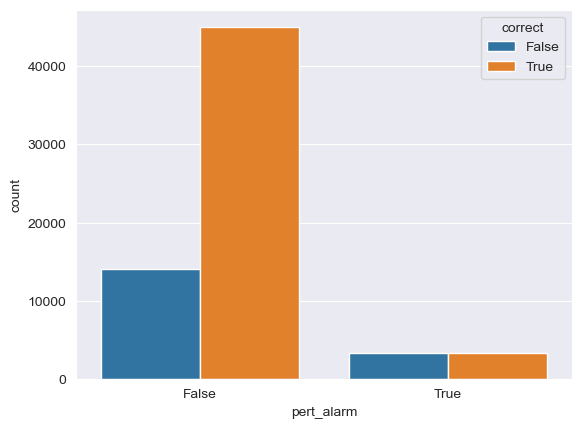

In [52]:
sns.countplot(data = pert_test_results, x="pert_alarm", hue="correct")

In [53]:
def correct_mistakes(row):
    if row.pert_alarm:
        return row.y_true
    else:
        return row.y

def force_mistakes(row):
    if row.worsened >= 0.3 and row.changed_to:
        return random.sample(row.changed_to,1)[0]
    else:
        return row.y

def force_corrections(row):
    if row.corrected >= 0.3:
        return row.y_true
    else:
        return row.y

pert_test_results["y_corrected"] = pert_test_results.apply(correct_mistakes, axis="columns")
pert_test_results["y_forced_mistake"] = pert_test_results.apply(force_mistakes, axis="columns")
pert_test_results["y_forced_correction"] = pert_test_results.apply(force_corrections, axis="columns")

C:\Users\chrig\AppData\Local\Temp\ipykernel_3528\462870279.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return random.sample(row.changed_to,1)[0]


In [54]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


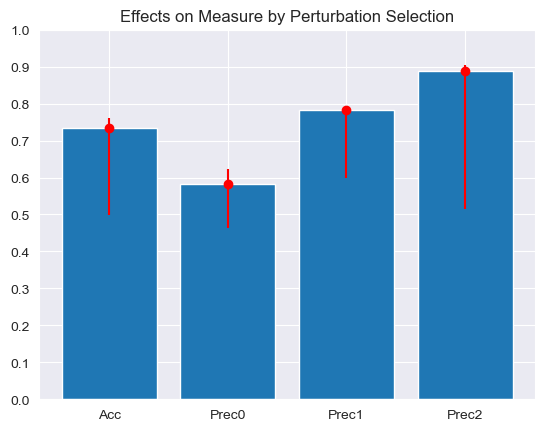

In [55]:
y_errormin = [alarm.get("acc"), alarm.get("prec0"), alarm.get("prec1"), alarm.get("prec2")]
y_errormax = [no_alarm.get("acc"), no_alarm.get("prec0"), no_alarm.get("prec1"), no_alarm.get("prec2")]
y_error = [y_errormin, y_errormax]
y = [real.get("acc"), real.get("prec0"), real.get("prec1"), real.get("prec2")]
for c, v in enumerate(y_errormin):
    y_errormin[c] = y[c] - v
for c, v in enumerate(y_errormax):
    y_errormax[c] = v - y[c]
x = ["Acc", "Prec0", "Prec1", "Prec2"]
plt.bar(x,y)
plt.errorbar(x,y, yerr=y_error, fmt='o', color="r")

plt.yticks(np.arange(start=0, stop=1.1, step = 0.1))
plt.title("Effects on Measure by Perturbation Selection")
plt.show()

In [56]:
print(f"Real values {real}")
print(f"Alarmed values {alarm}")
print(f"Non-alarmed values {no_alarm}")

Real values {'acc': 0.7342897524353733, 'prec0': 0.5829841594276954, 'prec1': 0.7822335673261008, 'prec2': 0.8877551020408163}
Alarmed values {'acc': 0.49770063788755375, 'prec0': 0.46241932125754737, 'prec1': 0.5975683890577508, 'prec2': 0.515358361774744}
Non-alarmed values {'acc': 0.761293599729089, 'prec0': 0.6221981445114105, 'prec1': 0.7903277378097522, 'prec2': 0.9038888067425699}


In [57]:
# Scores when all alerted entries are corrected
print_measures(list(pert_test_results["y_corrected"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.78575
Precision-µ: 0.78575
Recall-µ: 0.78575
F1-Score-µ: 0.78575
=
Precision-M: 0.79978
Recall-M: 0.75509
F1-Score-M: 0.77470
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.68242
Recall score: 0.67201
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.80882
Recall score: 0.84559
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.90811
Recall score: 0.74767


{'acc': 0.7857479369614444,
 'prec0': 0.6824158934365572,
 'prec1': 0.8088192419825073,
 'prec2': 0.9081142210913203}

In [58]:
# Scores when all alerted entries discarded
print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 59060
Accuracy: 0.76129
Precision-µ: 0.76129
Recall-µ: 0.76129
F1-Score-µ: 0.76129
=
Precision-M: 0.77214
Recall-M: 0.72635
F1-Score-M: 0.74628
--------------------
Measures for label '0'
Number of entries: 15039
Precision score: 0.62220
Recall score: 0.61094
--------------------
Measures for label '1'
Number of entries: 35740
Precision score: 0.79033
Recall score: 0.82991
--------------------
Measures for label '2'
Number of entries: 8281
Precision score: 0.90389
Recall score: 0.73820


{'acc': 0.761293599729089,
 'prec0': 0.6221981445114105,
 'prec1': 0.7903277378097522,
 'prec2': 0.9038888067425699}

In [59]:
#Scores when all strongly changed perturbations are corrected
print_measures(list(pert_test_results["y_forced_correction"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73447
Precision-µ: 0.73447
Recall-µ: 0.73447
F1-Score-µ: 0.73447
=
Precision-M: 0.75123
Recall-M: 0.71576
F1-Score-M: 0.73045
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58325
Recall score: 0.63955
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78230
Recall score: 0.77866
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88813
Recall score: 0.72905


{'acc': 0.7344721204844911,
 'prec0': 0.5832523899596135,
 'prec1': 0.7823002526348024,
 'prec2': 0.8881327094853254}

In [60]:
#Scores when all strongly changed perturbations are changed to wrong entries
print_measures(list(pert_test_results["y_forced_mistake"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73420
Precision-µ: 0.73420
Recall-µ: 0.73420
F1-Score-µ: 0.73420
=
Precision-M: 0.75092
Recall-M: 0.71549
F1-Score-M: 0.73016
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58291
Recall score: 0.63944
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78213
Recall score: 0.77833
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88771
Recall score: 0.72870


{'acc': 0.7341985684108144,
 'prec0': 0.582911748173131,
 'prec1': 0.7821281809132443,
 'prec2': 0.887707358570821}

## Local Accuracy

In [61]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


In [62]:
# Finding corresponding indexes
correct_indexes = pert_test_results.index[pert_test_results['correct'] == True].tolist()
false_indexes = pert_test_results.index[pert_test_results['correct'] == False].tolist()
alarm_indexes = pert_test_results.index[pert_test_results['pert_alarm'] == True].tolist()

In [63]:
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [64]:
# Find correct vs false fraction
frac_fc = len(false_indexes) / len(correct_indexes) 
frac_alarm = len(alarm_indexes) / len(X_test.index)
print(f"Fraction false vs. correct is: {frac_fc:.4f} (Rounded)")
print(f"Fraction alarm vs. no alarm is: {frac_alarm:.4f} (Rounded)")

Fraction false vs. correct is: 0.3619 (Rounded)
Fraction alarm vs. no alarm is: 0.1024 (Rounded)


In [65]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from main.utils import time_utils

# Scaling Test-Data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test, y_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Sample X_test
sample_idxs = list(pert_test_results.groupby("pert_alarm", group_keys=False).apply(lambda x: x.sample(frac = 0.1)).index.astype(int))
X_test_sampled = X_test_scaled.loc[sorted(sample_idxs)]
X_test_sampled.index = range(len(X_test_sampled.index))
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,-0.191709,-0.489611,-0.506330,-1.179173,0.876772,1.489818,-0.509749,-0.927218,0.748371,-0.176153,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.041369,-0.432882,1.454353,-1.179173,0.876772,1.358293,-0.666376,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,-0.191709,1.136619,-1.595598,-1.179173,0.876772,0.046107,-1.070582,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,0.624422,-0.754346,-0.506330,-1.179173,0.876772,1.563225,-0.401115,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.299095,0.002040,-1.595598,-1.179173,0.876772,-0.906951,1.370283,0.019505,-0.519148,-0.642610,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.191709,-0.659797,-0.615257,-1.179173,0.876772,0.924965,-0.980116,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,0.066017,-0.054689,-1.486671,-1.179173,0.876772,-0.053170,-1.042338,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,0.237834,-0.224876,-0.669720,-1.179173,0.876772,0.966028,-0.959995,0.650654,0.976168,0.194826,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [66]:
# Sample y_test
y_test_true_sampled = y_test.loc[sorted(sample_idxs)]
y_test_true_sampled.index = range(len(y_test_true_sampled.index))

y_test_pred_sampled = y_test_pred.copy()
y_test_pred_sampled.index = y_test.index
y_test_pred_sampled = y_test_pred_sampled.loc[sorted(sample_idxs)]
y_test_pred_sampled.index = range(len(y_test_pred_sampled.index))
y_test_pred_sampled

,0
0,1
1,1
2,1
3,1
4,2
...,...
6575,0
6576,1
6577,1
6578,1


In [67]:
def calc_manh_dist_matrix(X: pd.DataFrame):   
    X = X.to_numpy()
    n = X.shape[0]
    D = np.zeros((n,n))
    D_asym = np.zeros((n,n))
    start, start_str = time_utils.print_time()
    print(f"Start distance calc at {start_str}")
    for i in range(n):
        print(f"{i+1}/{n}:")
        for j in range(i,n):
            D[i,j] = distance.cityblock(X[i], X[j])
            D[j,i] =  D[i,j]
            D_asym[i,j] = D[i,j]
            D_asym[j,i] = np.nan
    end, end_str = time_utils.print_time()
    print(f"End distance calc at {end_str}\n Took time: {end-start}")
    return D, D_asym

In [68]:
distance_matrix, dist_matrix_asym = calc_manh_dist_matrix(X_test_sampled)
distance_matrix

Start distance calc at 2024_10_28 02:36
1/6580:
2/6580:
3/6580:
4/6580:
5/6580:
6/6580:
7/6580:
8/6580:
9/6580:
10/6580:
11/6580:
12/6580:
13/6580:
14/6580:
15/6580:
16/6580:
17/6580:
18/6580:
19/6580:
20/6580:
21/6580:
22/6580:
23/6580:
24/6580:
25/6580:
26/6580:
27/6580:
28/6580:
29/6580:
30/6580:
31/6580:
32/6580:
33/6580:
34/6580:
35/6580:
36/6580:
37/6580:
38/6580:
39/6580:
40/6580:
41/6580:
42/6580:
43/6580:
44/6580:
45/6580:
46/6580:
47/6580:
48/6580:
49/6580:
50/6580:
51/6580:
52/6580:
53/6580:
54/6580:
55/6580:
56/6580:
57/6580:
58/6580:
59/6580:
60/6580:
61/6580:
62/6580:
63/6580:
64/6580:
65/6580:
66/6580:
67/6580:
68/6580:
69/6580:
70/6580:
71/6580:
72/6580:
73/6580:
74/6580:
75/6580:
76/6580:
77/6580:
78/6580:
79/6580:
80/6580:
81/6580:
82/6580:
83/6580:
84/6580:
85/6580:
86/6580:
87/6580:
88/6580:
89/6580:
90/6580:
91/6580:
92/6580:
93/6580:
94/6580:
95/6580:
96/6580:
97/6580:
98/6580:
99/6580:
100/6580:
101/6580:
102/6580:
103/6580:
104/6580:
105/6580:
106/6580:
107/6580

array([[ 0.        , 27.98949777, 11.30788891, ..., 22.39843249,
        22.22378827, 21.67806336],
       [27.98949777,  0.        , 32.71160631, ..., 41.76608207,
        38.32742639, 39.86049064],
       [11.30788891, 32.71160631,  0.        , ..., 27.16340599,
        28.29713525, 28.009136  ],
       ...,
       [22.39843249, 41.76608207, 27.16340599, ...,  0.        ,
         6.93595041,  2.45550989],
       [22.22378827, 38.32742639, 28.29713525, ...,  6.93595041,
         0.        ,  5.40796431],
       [21.67806336, 39.86049064, 28.009136  , ...,  2.45550989,
         5.40796431,  0.        ]])

In [69]:
np.fill_diagonal(distance_matrix, np.nan)
distance_matrix

array([[        nan, 27.98949777, 11.30788891, ..., 22.39843249,
        22.22378827, 21.67806336],
       [27.98949777,         nan, 32.71160631, ..., 41.76608207,
        38.32742639, 39.86049064],
       [11.30788891, 32.71160631,         nan, ..., 27.16340599,
        28.29713525, 28.009136  ],
       ...,
       [22.39843249, 41.76608207, 27.16340599, ...,         nan,
         6.93595041,  2.45550989],
       [22.22378827, 38.32742639, 28.29713525, ...,  6.93595041,
                nan,  5.40796431],
       [21.67806336, 39.86049064, 28.009136  , ...,  2.45550989,
         5.40796431,         nan]])

In [70]:
distance_list = distance_matrix.flatten()
distance_list = list(distance_list[~np.isnan(distance_list)])

print(f"Number of entries: {len(distance_list)}")

Number of entries: 43289820


<AxesSubplot:>

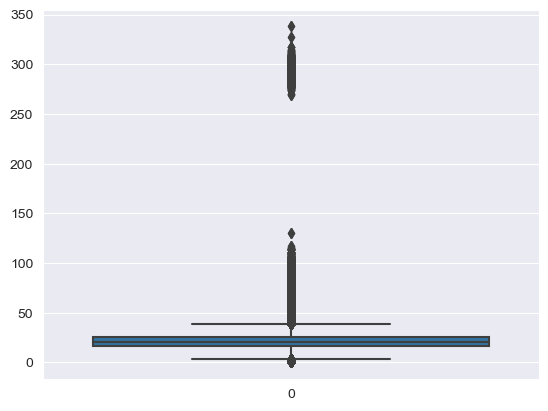

In [71]:
sns.boxplot(distance_list)

In [72]:
neigh_thresh = np.percentile(distance_list,0.2)
neigh_thresh

6.5868090777053725

In [73]:
np.fill_diagonal(dist_matrix_asym, 0)
boolean_mask = np.where((dist_matrix_asym < neigh_thresh) & (~np.isnan(dist_matrix_asym)), True, False)
boolean_mask

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [74]:
true_indices_list = []
for row in boolean_mask:
    true_indices = np.where(row)[0]
    true_indices_list.append(true_indices.tolist())
true_indices_list

[[0],
 [1],
 [2, 5],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9, 13],
 [10, 24],
 [11],
 [12],
 [13, 19, 5746, 5749, 5758],
 [14],
 [15],
 [16, 6401],
 [17],
 [18],
 [19],
 [20, 6079],
 [21],
 [22],
 [23, 27],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30, 6404],
 [31, 37],
 [32,
  33,
  34,
  36,
  41,
  354,
  652,
  669,
  672,
  675,
  1034,
  1538,
  1583,
  1589,
  1724,
  1725,
  1728,
  2117,
  2122,
  2124,
  2127,
  2722,
  2849,
  3689,
  3840,
  4740,
  5481,
  5498,
  5714,
  5730,
  6425,
  6426,
  6433,
  6434],
 [33,
  35,
  36,
  40,
  1574,
  1583,
  1732,
  1734,
  2122,
  2123,
  2130,
  3122,
  5489,
  6192,
  6426,
  6434],
 [34, 1583, 1589, 2101, 2121, 2122, 2125, 2126],
 [35, 39, 669, 1734, 2117, 2123, 4265, 4738, 4858, 5487, 5489],
 [36,
  39,
  40,
  1574,
  1579,
  1588,
  1723,
  1726,
  2095,
  2112,
  2118,
  2847,
  3686,
  3706,
  4254,
  5497,
  5724,
  5726,
  6430],
 [37],
 [38, 676],
 [39, 40, 1574, 1723, 1726, 1983, 2123, 2128, 2710, 3132, 4254, 4257,

In [75]:
np.median([len(elem) for elem in true_indices_list])

4.0

In [76]:
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,-0.191709,-0.489611,-0.506330,-1.179173,0.876772,1.489818,-0.509749,-0.927218,0.748371,-0.176153,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.041369,-0.432882,1.454353,-1.179173,0.876772,1.358293,-0.666376,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,-0.191709,1.136619,-1.595598,-1.179173,0.876772,0.046107,-1.070582,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,0.624422,-0.754346,-0.506330,-1.179173,0.876772,1.563225,-0.401115,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.299095,0.002040,-1.595598,-1.179173,0.876772,-0.906951,1.370283,0.019505,-0.519148,-0.642610,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.191709,-0.659797,-0.615257,-1.179173,0.876772,0.924965,-0.980116,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,0.066017,-0.054689,-1.486671,-1.179173,0.876772,-0.053170,-1.042338,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,0.237834,-0.224876,-0.669720,-1.179173,0.876772,0.966028,-0.959995,0.650654,0.976168,0.194826,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [77]:
pert_test_results.index = pert_test_results.index.astype(int)
pert_test_results_sampled = pert_test_results.loc[sample_idxs]
pert_test_results_sampled.index = range(len(pert_test_results_sampled.index))
pert_test_results_sampled

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
0,0,0,False,{0},{},0.000000,0.000000,True,0,0,0
1,0,1,False,{1},{},0.000000,0.000000,False,1,1,1
2,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
3,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
4,2,2,False,{2},{},0.000000,0.000000,True,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
6575,1,0,True,"{0, 1}",{1},0.032258,0.000000,False,1,0,0
6576,1,1,True,"{1, 2}",{2},0.000000,0.096774,True,1,1,1
6577,0,0,True,"{0, 1}",{1},0.000000,0.064516,True,0,0,0
6578,0,0,True,"{0, 1}",{1},0.000000,0.032258,True,0,0,0


In [78]:
res_list = []
for list in true_indices_list:
    res_list.append(accuracy_score(y_test_true_sampled.loc[list], y_test_pred_sampled.loc[list]))
res_list 

[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 0.6764705882352942,
 0.6875,
 0.5,
 0.8181818181818182,
 0.8421052631578947,
 1.0,
 0.5,
 0.8461538461538461,
 0.7272727272727273,
 0.6923076923076923,
 0.375,
 0.6,
 0.7142857142857143,
 0.7142857142857143,
 0.8571428571428571,
 0.875,
 0.8333333333333334,
 0.6666666666666666,
 0.6666666666666666,
 0.5714285714285714,
 0.8,
 0.8,
 1.0,
 1.0,
 1.0,
 0.875,
 0.8,
 0.25,
 0.7272727272727273,
 0.8,
 1.0,
 1.0,
 0.75,
 0.5,
 0.5,
 0.5833333333333334,
 0.5,
 0.5454545454545454,
 0.8,
 0.75,
 1.0,
 0.875,
 0.6666666666666666,
 0.625,
 1.0,
 0.625,
 0.75,
 0.5,
 0.6666666666666666,
 0.5,
 0.8571428571428571,
 0.8333333333333334,
 0.75,
 0.75,
 0.7272727272727273,
 0.9,
 1.0,
 0.7368421052631579,
 0.5,
 0.6,
 1.0,
 0.6190476190476191,
 0.5384615384615384,
 1.0,
 1.0,
 0.3333333333333333,
 1.0,
 0.7083333

In [79]:
alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == True].index
no_alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == False].index

alarm_acc = np.mean([res_list[i] for i in alarm_idx])
no_alarm_acc = np.mean([res_list[i] for i in no_alarm_idx]) 

In [80]:
alarm_acc

0.7104045476449037

In [81]:
no_alarm_acc

0.74627634085234

In [82]:
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [83]:
corr_df = pert_test_results[pert_test_results["corrected"] > 0.1]
corr_df

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10026093,1,0,True,"{0, 1}",{1},0.193548,0.0,False,1,0,0
10055239,1,0,True,"{0, 1}",{1},0.161290,0.0,False,1,0,0
10055554,1,0,True,"{0, 1}",{1},0.225806,0.0,False,1,0,0
10066841,0,1,True,"{0, 1}",{0},0.161290,0.0,False,0,1,1
10075464,0,1,True,"{0, 1}",{0},0.193548,0.0,False,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9931215,1,0,True,"{0, 1}",{1},0.193548,0.0,False,1,0,0
9979208,0,1,True,"{0, 1}",{0},0.129032,0.0,False,0,1,1
9979664,1,0,True,"{0, 1}",{1},0.161290,0.0,False,1,0,0


In [84]:
exp = pert_test_results[pert_test_results["pert_alarm"]]
exp_idx = exp.index.astype(str).tolist()
exp = pert_view[pert_view["idx"].isin(exp_idx)]
exp = exp[exp["level"] > 1]
exp

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10033431>,2,3,2,1HOUR_PRECIPITATION(INCH),0.000,10033431,False,False,{2},[],False,False
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False,"{0, 1}",[1],False,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10042837>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10042837,False,False,{1},[],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9988578>,1,3,0,WIND_SPEED(KMH),11.112,9988578,False,True,{0},[],False,False
WIND_SPEED(KMH)<9995030>,1,3,1,WIND_SPEED(KMH),12.964,9995030,False,False,{1},[],False,False
WIND_SPEED(KMH)<9997432>,1,3,0,WIND_SPEED(KMH),12.964,9997432,False,True,{0},[],False,False


In [85]:
exp = exp[exp["pert_alarm"]]
exp

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10026093,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10042426>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042426,True,False,"{0, 1}",[1],False,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10042665,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055239,True,True,"{0, 1}",[1],True,False
1HOUR_PRECIPITATION(INCH)<10055441>,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,10055441,True,False,"{0, 1}",[1],False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
WIND_SPEED(KMH)<9953591>,0,3,0,WIND_SPEED(KMH),25.928,9953591,True,False,"{0, 1}",[1],False,True
WIND_SPEED(KMH)<9967800>,1,3,1,WIND_SPEED(KMH),16.668,9967800,True,False,"{1, 2}",[2],False,True
WIND_SPEED(KMH)<9979208>,0,3,1,WIND_SPEED(KMH),13.890,9979208,True,True,"{0, 1}",[0],True,False


In [86]:
def select_random_row(group):
    return group.sample(n=1)

result = exp.groupby("column").apply(select_random_row)
result

,,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
column,pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH),1HOUR_PRECIPITATION(INCH)<7923132>,1,3,0,1HOUR_PRECIPITATION(INCH),0.000000,7923132,True,True,"{0, 1}",[1],True,False
APPROACH_SPEED(KMH),APPROACH_SPEED(KMH)<6730178>,1,2,0,APPROACH_SPEED(KMH),255.576000,6730178,True,True,"{0, 1}",[1],True,False
DEWPOINT_TEMP(C),DEWPOINT_TEMP(C)<10075464>,0,3,1,DEWPOINT_TEMP(C),19.388889,10075464,True,True,"{0, 1}",[0],True,False
PARKING_AREA(SQM),PARKING_AREA(SQM)<6427607>,1,2,0,PARKING_AREA(SQM),1525.176514,6427607,True,True,"{0, 1}",[1],True,False
REL_HUMIDITY(PERCENT),REL_HUMIDITY(PERCENT)<5948103>,0,3,0,REL_HUMIDITY(PERCENT),92.770000,5948103,True,False,"{0, 1}",[1],False,True
RUNWAY_ERROR(PERC),RUNWAY_ERROR(PERC)<7612777>,0,3,1,RUNWAY_ERROR(PERC),0.600000,7612777,True,True,"{0, 1}",[0],True,False
SEA_LEVEL_PRESSURE(MILLIBAR),SEA_LEVEL_PRESSURE(MILLIBAR)<6246983>,0,3,0,SEA_LEVEL_PRESSURE(MILLIBAR),1020.100000,6246983,True,False,"{0, 1}",[1],False,True
TAIL_HEIGHT(M),TAIL_HEIGHT(M)<10806716>,1,2,0,TAIL_HEIGHT(M),12.100560,10806716,True,True,"{0, 1}",[1],True,False
TEMP(C),TEMP(C)<9234884>,1,3,0,TEMP(C),21.722222,9234884,True,True,"{0, 1}",[1],True,False


In [87]:
X_csv = X_test.loc[result["idx"].astype(int)]
X_csv

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
7923132,-5,149,88,0.433884,-0.900969,0.612217,-0.790690,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.8
6730178,-2,78,67,-0.433884,-0.900969,-0.826590,-0.562805,255.576,9.000744,1525.176514,...,0,0,0,0,2,0,0,0,0,0.2
10075464,-5,102,69,0.433884,-0.900969,-0.876727,-0.480989,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.8
6427607,-3,123,54,-0.974928,-0.222521,0.488621,-0.872496,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.4
5948103,-10,132,82,0.000000,1.000000,0.566406,-0.824126,259.280,6.324600,560.293571,...,0,0,0,0,0,0,1,0,0,0.6
7612777,-7,77,58,-0.433884,-0.900969,-0.962455,-0.271440,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.6
6246983,-8,90,55,0.000000,1.000000,0.321439,-0.946930,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,1.0
10806716,-3,100,62,0.974928,-0.222521,-0.961262,0.275637,259.280,12.100560,1517.837235,...,2,0,0,0,0,0,0,0,0,1.0
9234884,-5,136,61,-0.974928,-0.222521,0.337917,-0.941176,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
5637056,-4,125,64,0.000000,1.000000,-0.831470,-0.555570,255.576,9.000744,1525.176514,...,2,0,0,0,0,0,0,0,0,1.0


In [88]:
X_csv.to_csv("pert_cases.csv", sep=",")